In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

import utils

with open('../screenlog.0') as f:
    text = f.read()
with open('../screenlog.own') as f:
    text += f.read()
runs = text.split("--------------------------------------------------------------\n")
runs = runs[1:]

info = runs[0].split("\n")
info = info[0].split(",")
infoheader = []
for i in info:
    infoheader.append(i.split(":")[0].strip())

infoheader.append("File")
infoheader.append("Status")

value_list = []
for run in runs:
    if "SKIPPED" not in run:
        info = run.split("\n")
        info = info[0].split(",")
        values = []
        for i in info:
            values.append(i.split(":")[1].strip())
        
        model = values[2][:-7]
        file = f"{model}_{values[-1]}_d{values[1]}_m{values[0]}_t{values[-3]}.log"
        values.append(file)

        if "ERROR" in run:
            values.append("ERROR")
            remove_path = os.path.join("../memory", file)
            if os.path.exists(remove_path):
                os.remove(remove_path)
        elif "amdgpu" in run:
            values.append("OUT OF MEMORY")
        elif "Killed" in run:
            values.append("KILLED")
        else:
            values.append("SUCCESS")

        value_list.append(values)
run_df = pd.DataFrame(value_list, columns=infoheader)
run_df

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
0,2,1,yolo_models,1,32,1,1,32-fp16.tflite,yolo_32-fp16.tflite_d1_m2_t1.log,SUCCESS
1,2,1,yolo_models,1,192,1,1,192-fp16.tflite,yolo_192-fp16.tflite_d1_m2_t1.log,SUCCESS
2,2,1,yolo_models,1,480,1,1,480-fp16.tflite,yolo_480-fp16.tflite_d1_m2_t1.log,SUCCESS
3,2,1,yolo_models,1,288,1,1,288-fp16.tflite,yolo_288-fp16.tflite_d1_m2_t1.log,SUCCESS
4,2,1,yolo_models,1,672,1,1,672-fp16.tflite,yolo_672-fp16.tflite_d1_m2_t1.log,SUCCESS
...,...,...,...,...,...,...,...,...,...,...
899,4,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m4_t1.log,SUCCESS
900,5,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m5_t1.log,SUCCESS
901,6,0,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m6_t1.log,SUCCESS
902,2,0,yolo_models,1,3744,1,1,3744-fp16.tflite,yolo_3744-fp16.tflite_d0_m2_t1.log,KILLED


# YOLOv5

## One by one

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
7,2,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m2_t1.log,SUCCESS


,VIRT,RES,SHR,CPU%,% Run,File
0,1.796004,0.066920,48.072,6.6,0.293988,yolo_1440-fp16.tflite_d1_m2_t1.log
1,1.834488,0.128184,79.056,99.7,4.718507,yolo_1440-fp16.tflite_d1_m2_t1.log
2,1.842188,0.133120,79.404,100.0,9.157725,yolo_1440-fp16.tflite_d1_m2_t1.log
3,1.842188,0.133724,79.596,100.0,13.596943,yolo_1440-fp16.tflite_d1_m2_t1.log
4,1.842188,0.133768,79.596,100.3,18.050860,yolo_1440-fp16.tflite_d1_m2_t1.log
...,...,...,...,...,...,...
59,2.239868,0.485224,80.676,1.7,99.706012,yolo_1440-fp16.tflite_d1_m2_t1.log
60,2.239868,0.485224,80.676,1.7,99.779509,yolo_1440-fp16.tflite_d1_m2_t1.log
61,2.239868,0.485224,80.676,1.3,99.838307,yolo_1440-fp16.tflite_d1_m2_t1.log
62,2.239868,0.485224,80.676,1.7,99.911804,yolo_1440-fp16.tflite_d1_m2_t1.log


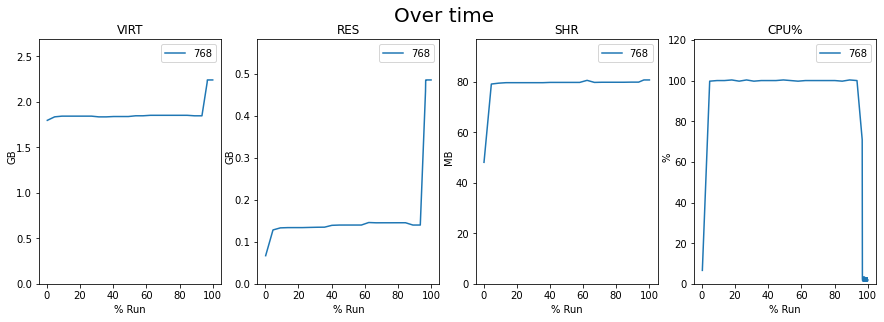

In [5]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

df, maxesmethod1, _ = utils.get_data(selected, verbose=False)
display(df)
utils.plot_analyse(df, ["768"], title="Over time")


## Different Methods

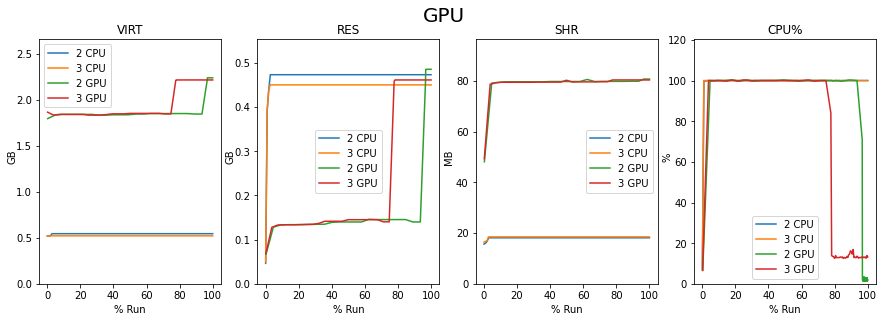

,VIRT,RES,SHR,CPU%,% Run,File
22,2.212656,0.458020,80.676,70.9,96.648537,yolo_1440-fp16.tflite_d1_m2_t1.log
23,2.239868,0.484984,80.676,2.6,96.766133,yolo_1440-fp16.tflite_d1_m2_t1.log
24,2.239868,0.484984,80.676,1.7,96.839630,yolo_1440-fp16.tflite_d1_m2_t1.log
25,2.239868,0.484984,80.676,1.7,96.913127,yolo_1440-fp16.tflite_d1_m2_t1.log
26,2.239868,0.484984,80.676,1.7,96.986624,yolo_1440-fp16.tflite_d1_m2_t1.log
27,2.239868,0.485224,80.676,3.3,97.133618,yolo_1440-fp16.tflite_d1_m2_t1.log
28,2.239868,0.485224,80.676,1.3,97.192415,yolo_1440-fp16.tflite_d1_m2_t1.log
29,2.239868,0.485224,80.676,1.7,97.265912,yolo_1440-fp16.tflite_d1_m2_t1.log
30,2.239868,0.485224,80.676,1.7,97.339409,yolo_1440-fp16.tflite_d1_m2_t1.log
31,2.239868,0.485224,80.676,1.3,97.398207,yolo_1440-fp16.tflite_d1_m2_t1.log


In [3]:
selected = run_df[(run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']=="1440") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = ["2 CPU", "3 CPU"]
df1, maxesmethod1 = utils.get_data(selected, verbose=False)

selected = run_df[(run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']=="1440") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = ["2 CPU", "3 CPU", "2 GPU", "3 GPU"]
df2, maxesmethod1 = utils.get_data(selected, verbose=False)

utils.plot_analyse(pd.concat([df1, df2]), labels, title="GPU")
df2[df2["% Run"] > 96]

## image sizes

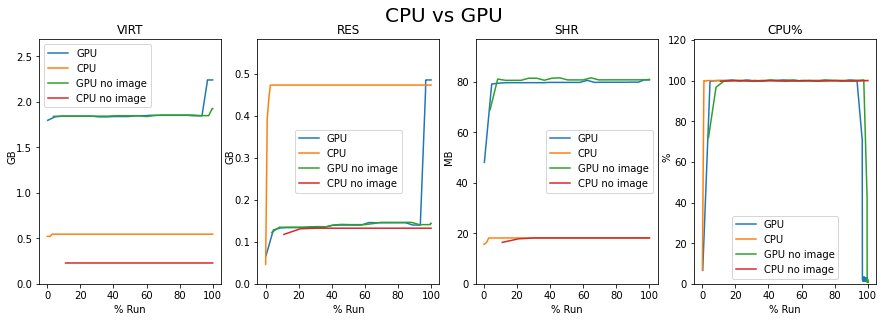

In [7]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']=="1440") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsyolo = ["GPU", "CPU", "GPU no image", "CPU no image"]
df, maxesmethod1, _ = utils.get_data(selected, verbose=False)



axes = utils.plot_analyse(df, labelsyolo, title="CPU vs GPU", plot=False)
path = f"/home/sara/Documents/Master-thesis/TFLite/memory/onlyinference"
df_log = utils.read_log_file(path)
for i,p in enumerate(['VIRT', 'RES', 'SHR', 'CPU%']):
    df_log.plot(x="% Run", y=p, ax=axes[i])

path = f"/home/sara/Documents/Master-thesis/TFLite/memory/onlyinference_cpu"
df_log = utils.read_log_file(path)
for i,p in enumerate(['VIRT', 'RES', 'SHR', 'CPU%']):
    df_log.plot(x="% Run", y=p, ax=axes[i])
    axes[i].legend(labelsyolo)

plt.show()


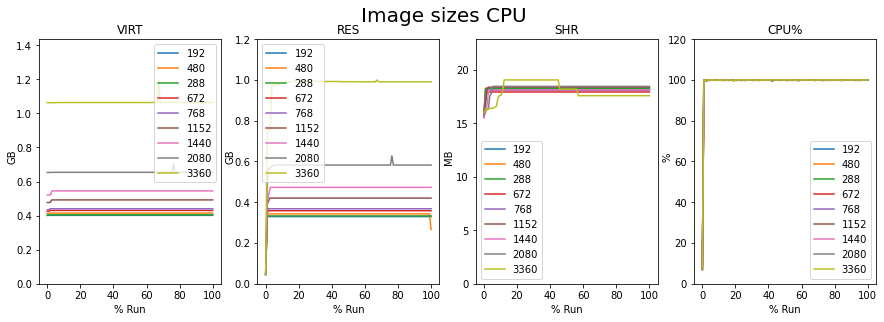

In [8]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']!="4000") & 
                    (run_df['Size']!="3744") & 
                    (run_df['Size']!="3712") & 
                    (run_df['Size']!="32") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsyolo = selected["Size"].unique()
df, maxesmethod1, _ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labelsyolo, title="Image sizes CPU")

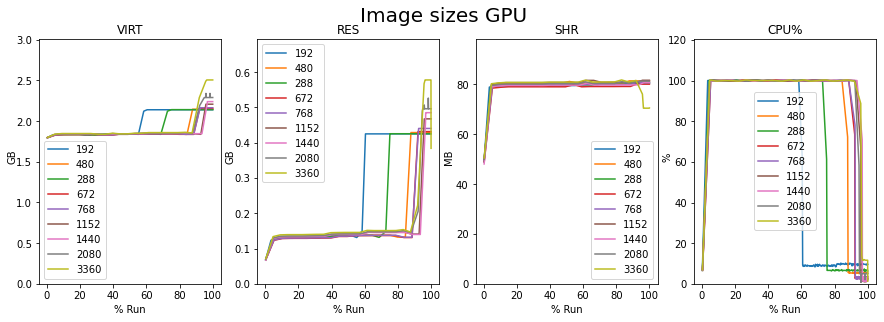

In [9]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']!="32") & 
                    (run_df['Size']!="4000") & 
                    (run_df['Size']!="3744") & 
                    (run_df['Size']!="3712") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsyolo = selected["Size"].unique()
df, maxesmethod2,_ = utils.get_data(selected, verbose=False)

df.to_csv("memory.csv")

utils.plot_analyse(df, labelsyolo, title="Image sizes GPU")

Average diff VIRT: 1.6679688888888888
Average diff RES: 0.11130133333333332
Average diff SHR: 62.67644444444444
Average diff CPU%: 0.26666666666666416


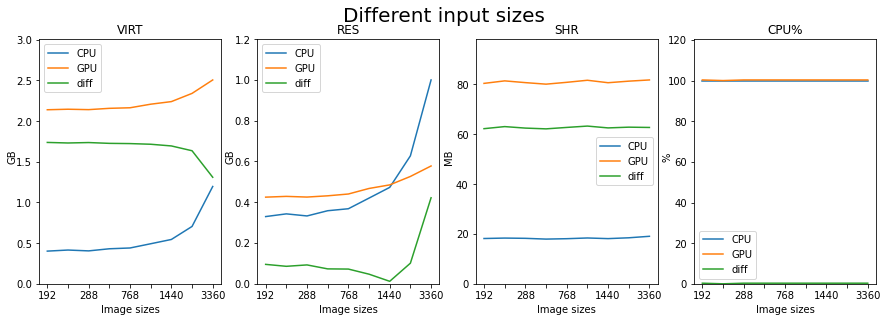

In [12]:
utils.plot_maxes([maxesmethod1, maxesmethod2], legends=["CPU", "GPU"], x_axis=labelsyolo, x_label="Image sizes", title="Different input sizes", plot_diff=True)

In [14]:
for i in maxesmethod1:
    print(i.values)
for i in maxesmethod2:
    print(i.values)

[  0.40172    0.329772  18.172    100.       100.      ]
[  0.415     0.34306  18.344   100.      100.     ]
[  0.404652   0.332856  18.244    100.       100.      ]
[  0.430604   0.35846   17.936    100.       100.      ]
[  0.44036    0.368216  18.096    100.       100.      ]
[  0.492376   0.420472  18.384    100.       100.      ]
[  0.54504    0.472992  18.128    100.       100.      ]
[  0.7051     0.627708  18.46     100.       100.      ]
[  1.196388   1.        19.06     100.       100.      ]
[  2.139688   0.425068  80.412    100.3      100.      ]
[  2.146156   0.428852  81.416    100.       100.      ]
[  2.141124   0.4255    80.716    100.3      100.      ]
[  2.157136   0.431632  80.1      100.3      100.      ]
[  2.16406   0.44048  80.836   100.3     100.     ]
[  2.208028   0.46768   81.664    100.3      100.      ]
[  2.239868   0.485224  80.676    100.3      100.      ]
[  2.340816   0.526612  81.304    100.3      100.      ]
[  2.506084   0.577992  81.788    100.3  

## Out of memory GPU

Including lines:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
1,2,1,yolo_models,1,192,1,1,192-fp16.tflite,yolo_192-fp16.tflite_d1_m2_t1.log,SUCCESS
2,2,1,yolo_models,1,480,1,1,480-fp16.tflite,yolo_480-fp16.tflite_d1_m2_t1.log,SUCCESS
3,2,1,yolo_models,1,288,1,1,288-fp16.tflite,yolo_288-fp16.tflite_d1_m2_t1.log,SUCCESS
4,2,1,yolo_models,1,672,1,1,672-fp16.tflite,yolo_672-fp16.tflite_d1_m2_t1.log,SUCCESS
5,2,1,yolo_models,1,768,1,1,768-fp16.tflite,yolo_768-fp16.tflite_d1_m2_t1.log,SUCCESS
6,2,1,yolo_models,1,1152,1,1,1152-fp16.tflite,yolo_1152-fp16.tflite_d1_m2_t1.log,SUCCESS
7,2,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m2_t1.log,SUCCESS
8,2,1,yolo_models,1,2080,1,1,2080-fp16.tflite,yolo_2080-fp16.tflite_d1_m2_t1.log,SUCCESS
9,2,1,yolo_models,1,3360,1,1,3360-fp16.tflite,yolo_3360-fp16.tflite_d1_m2_t1.log,SUCCESS
898,2,1,yolo_models,1,3712,1,1,3712-fp16.tflite,yolo_3712-fp16.tflite_d1_m2_t1.log,SUCCESS


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
897,2,1,yolo_models,1,3744,1,1,3744-fp16.tflite,yolo_3744-fp16.tflite_d1_m2_t1.log,KILLED


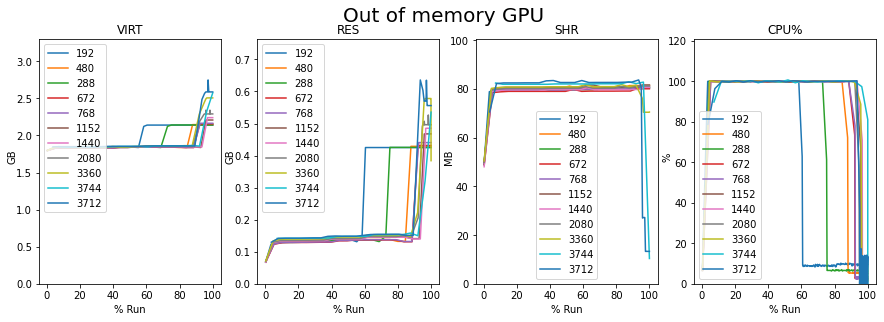

In [2]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Size']!="32") & 
                    (run_df['Size']!="4000") & 
                    #(run_df['Size']!="3712") & 
                    (run_df['Batch-size']=="1")]
file_name = run_df['File'].iloc[0]
labels = selected["Size"].unique()
df, maxes,_ = utils.get_data(selected, verbose=True)

utils.plot_analyse(df, labels, title="Out of memory GPU")

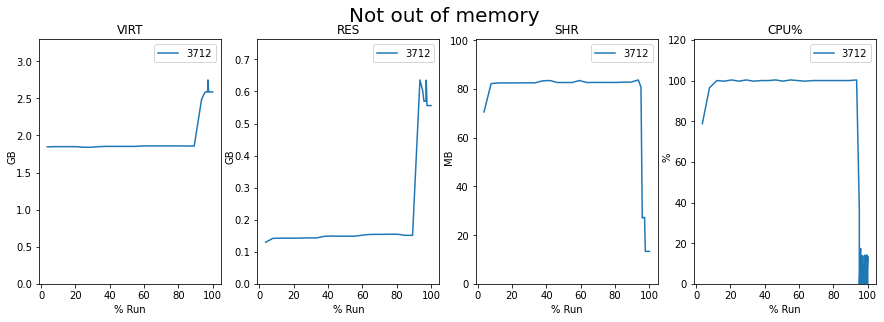

Max: 2.748132
Max: 0.635908
Max: 83.724
Max: 100.3


In [3]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3712") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["3712"]
df, maxes,_ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Not out of memory")
print(f"Max: {max(df['VIRT'].values)}")
print(f"Max: {max(df['RES'].values)}")
print(f"Max: {max(df['SHR'].values)}")
print(f"Max: {max(df['CPU%'].values)}")

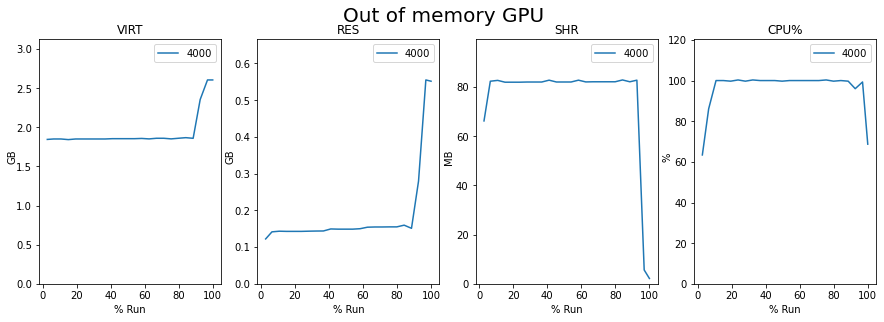

Max: 2.60404
Max: 0.555108
Max: 82.816
Max: 100.3


In [4]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="4000") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["4000"]
df, maxes,_ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Out of memory GPU")

print(f"Max: {max(df['VIRT'].values)}")
print(f"Max: {max(df['RES'].values)}")
print(f"Max: {max(df['SHR'].values)}")
print(f"Max: {max(df['CPU%'].values)}")

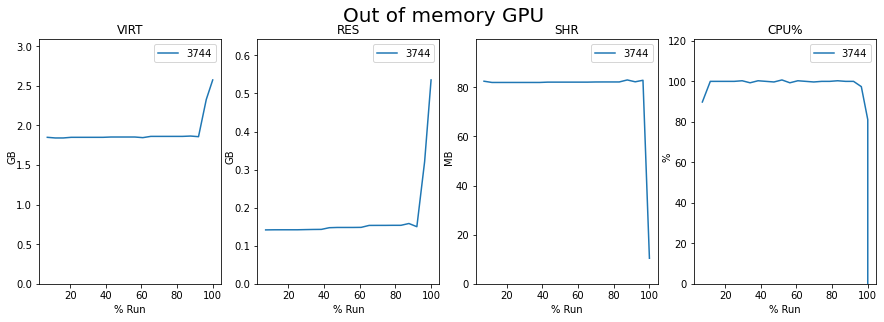

Max: 2.572988
Max: 0.535392
Max: 82.968
Max: 100.7


In [14]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3744") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["3744"]
df, maxes,_ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Out of memory GPU")
print(f"Max: {max(df['VIRT'].values)}")
print(f"Max: {max(df['RES'].values)}")
print(f"Max: {max(df['SHR'].values)}")
print(f"Max: {max(df['CPU%'].values)}")

## Out of memory CPU

Including lines:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
11,2,0,yolo_models,1,192,1,1,192-fp16.tflite,yolo_192-fp16.tflite_d0_m2_t1.log,SUCCESS
12,2,0,yolo_models,1,480,1,1,480-fp16.tflite,yolo_480-fp16.tflite_d0_m2_t1.log,SUCCESS
13,2,0,yolo_models,1,288,1,1,288-fp16.tflite,yolo_288-fp16.tflite_d0_m2_t1.log,SUCCESS
14,2,0,yolo_models,1,672,1,1,672-fp16.tflite,yolo_672-fp16.tflite_d0_m2_t1.log,SUCCESS
15,2,0,yolo_models,1,768,1,1,768-fp16.tflite,yolo_768-fp16.tflite_d0_m2_t1.log,SUCCESS
16,2,0,yolo_models,1,1152,1,1,1152-fp16.tflite,yolo_1152-fp16.tflite_d0_m2_t1.log,SUCCESS
17,2,0,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t1.log,SUCCESS
18,2,0,yolo_models,1,2080,1,1,2080-fp16.tflite,yolo_2080-fp16.tflite_d0_m2_t1.log,SUCCESS
19,2,0,yolo_models,1,3360,1,1,3360-fp16.tflite,yolo_3360-fp16.tflite_d0_m2_t1.log,SUCCESS
903,2,0,yolo_models,1,3712,1,1,3712-fp16.tflite,yolo_3712-fp16.tflite_d0_m2_t1.log,SUCCESS


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
902,2,0,yolo_models,1,3744,1,1,3744-fp16.tflite,yolo_3744-fp16.tflite_d0_m2_t1.log,KILLED


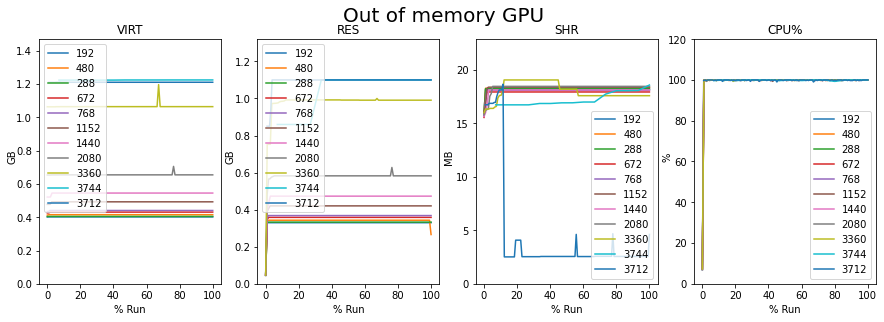

In [2]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Size']!="32") & 
                    (run_df['Size']!="4000") & 
                    #(run_df['Size']!="3712") & 
                    (run_df['Batch-size']=="1")]
file_name = run_df['File'].iloc[0]
labels = selected["Size"].unique()
df, maxes,_ = utils.get_data(selected, verbose=True)

utils.plot_analyse(df, labels, title="Out of memory CPU")

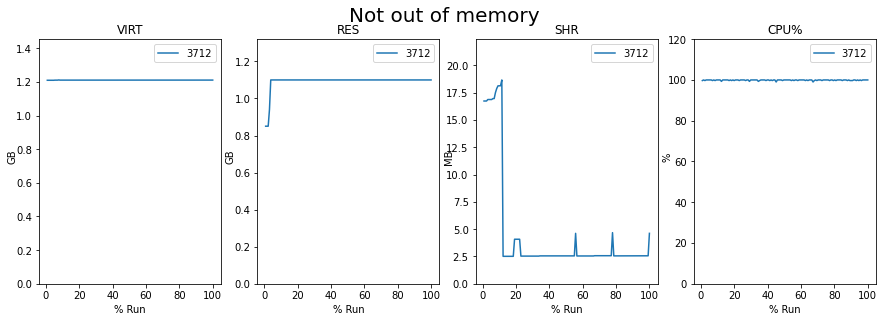

Max: 1.211372
Max: 1.1
Max: 18.664
Max: 100.0


In [3]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3712") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["3712"]
df, maxes,_ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Not out of memory")
print(f"Max: {max(df['VIRT'].values)}")
print(f"Max: {max(df['RES'].values)}")
print(f"Max: {max(df['SHR'].values)}")
print(f"Max: {max(df['CPU%'].values)}")

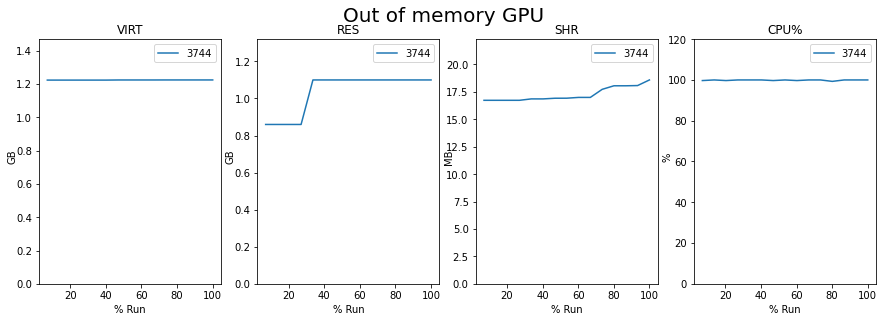

Max: 1.2244
Max: 1.1
Max: 18.588
Max: 100.0


In [5]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3744") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["3744"]
df, maxes,_ = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Out of memory CPU")
print(f"Max: {max(df['VIRT'].values)}")
print(f"Max: {max(df['RES'].values)}")
print(f"Max: {max(df['SHR'].values)}")
print(f"Max: {max(df['CPU%'].values)}")

## Frameworks

Including lines:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
7,2,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m2_t1.log,SUCCESS
17,2,0,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t1.log,SUCCESS
899,4,1,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d1_m4_t1.log,SUCCESS
901,6,0,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m6_t1.log,SUCCESS


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


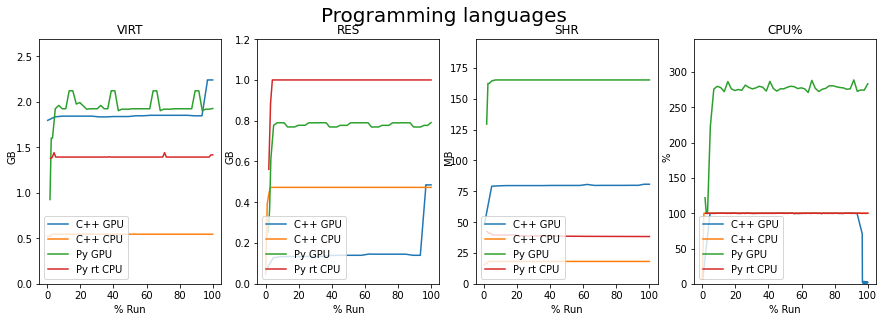

In [2]:
selected = run_df[(run_df['Method']!="1") & 
                    (run_df['Method']!="3") & 
                    (run_df['Method']!="5") & 
                    #(run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labels = ["C++ GPU", "C++ CPU", "Py GPU", "Py runtime CPU"]

df, maxesmethod1,_ = utils.get_data(selected, verbose=True)

utils.plot_analyse(df, labels, title="Programming languages")

## Threads

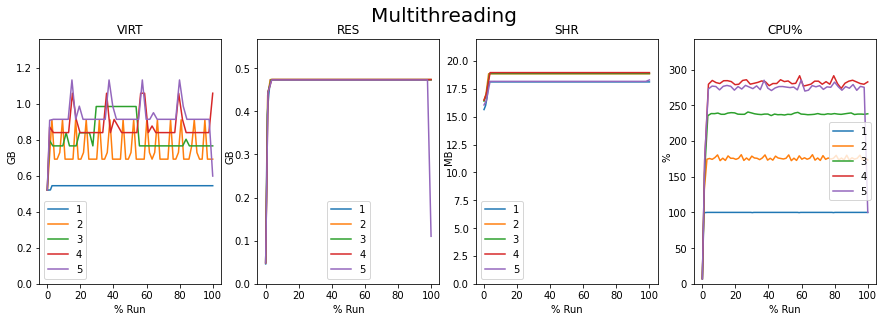

In [11]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    #(run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

file_name = run_df['File'].iloc[0]
labels = selected["Threads"].unique()

df, maxesmethod1 = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Multithreading")

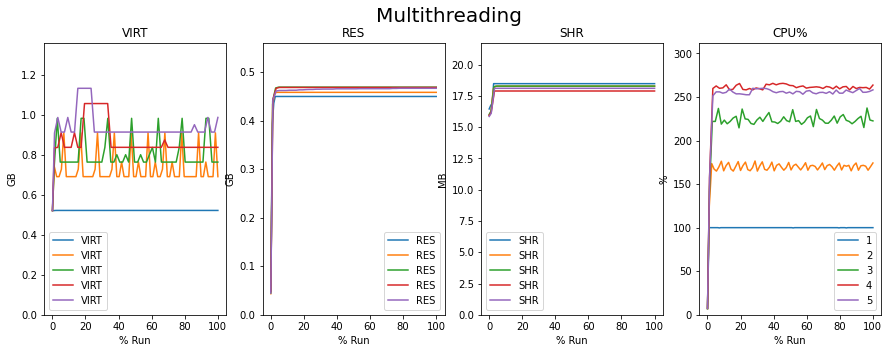

In [ ]:
selected = run_df[(run_df['Method']=="3") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    #(run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

file_name = run_df['File'].iloc[0]
labels = selected["Threads"].unique()

df, maxesmethod2 = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labels, title="Multithreading")

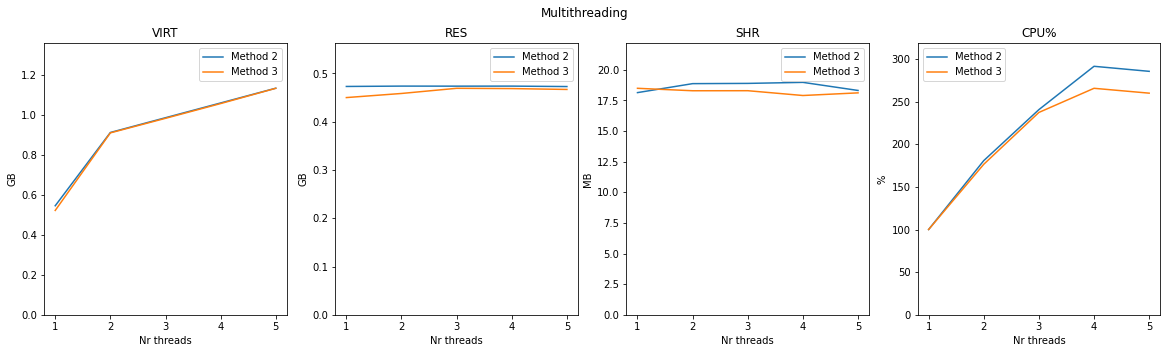

In [ ]:
utils.plot_maxes([maxesmethod1, maxesmethod2], legends=["Method 2", "Method 3"], x_axis=labels, x_label="Nr threads", title="Multithreading")

## Batch sizes

In [6]:
selected_all = run_df[(run_df['Method']=="3") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']!="1440") &
                    (run_df['Size']!="1152") &
                    (run_df['Size']!="2080") &
                    (run_df['Size']!="3360") &
                    (run_df['Size']!="4000") &
                    (run_df['Size']!="3744") &
                    (run_df['Size']!="3712") &
                    (run_df['Size']!="768") &
                    (run_df['Size']!="32") &
                    (run_df['Size']!="192") &
                    #(run_df['Size']!="288") &
                    (run_df['Status']!="ERROR") &
                    #(run_df['Batch-size']=="1") &
                    (run_df['Threads']=="1")]
selected_all["Size"] = pd.to_numeric(selected_all["Size"])
selected_all = selected_all.sort_values(by=["Size"])
labels = selected_all['Batch-size'].unique()
maxes_axis = selected_all['Size'].unique()
#utils.get_data(selected_all, verbose=True)
selected_all

/home/sara/anaconda3/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
43,3,1,yolo_models,1,288,1,1,288-fp16.tflite,yolo_288-fp16.tflite_d1_m3_t1.log,SUCCESS
267,3,1,yolo_models,1,288,1,2,288_2-fp16.tflite,yolo_288_2-fp16.tflite_d1_m3_t1.log,SUCCESS
491,3,1,yolo_models,1,288,1,3,288_3-fp16.tflite,yolo_288_3-fp16.tflite_d1_m3_t1.log,SUCCESS
715,3,1,yolo_models,1,288,1,4,288_4-fp16.tflite,yolo_288_4-fp16.tflite_d1_m3_t1.log,SUCCESS
42,3,1,yolo_models,1,480,1,1,480-fp16.tflite,yolo_480-fp16.tflite_d1_m3_t1.log,SUCCESS
266,3,1,yolo_models,1,480,1,2,480_2-fp16.tflite,yolo_480_2-fp16.tflite_d1_m3_t1.log,SUCCESS
490,3,1,yolo_models,1,480,1,3,480_3-fp16.tflite,yolo_480_3-fp16.tflite_d1_m3_t1.log,SUCCESS
714,3,1,yolo_models,1,480,1,4,480_4-fp16.tflite,yolo_480_4-fp16.tflite_d1_m3_t1.log,SUCCESS
44,3,1,yolo_models,1,672,1,1,672-fp16.tflite,yolo_672-fp16.tflite_d1_m3_t1.log,SUCCESS
268,3,1,yolo_models,1,672,1,2,672_2-fp16.tflite,yolo_672_2-fp16.tflite_d1_m3_t1.log,SUCCESS


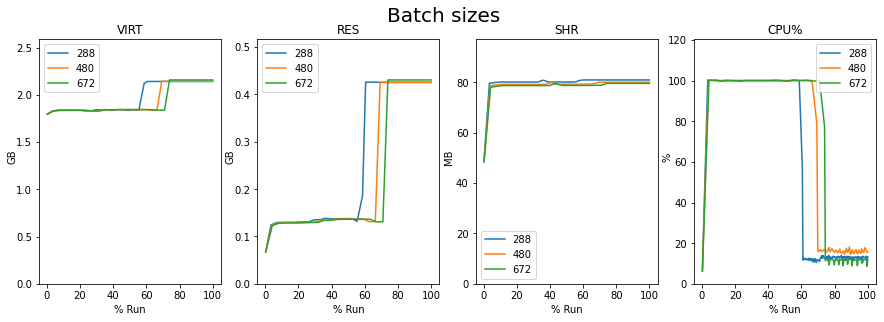

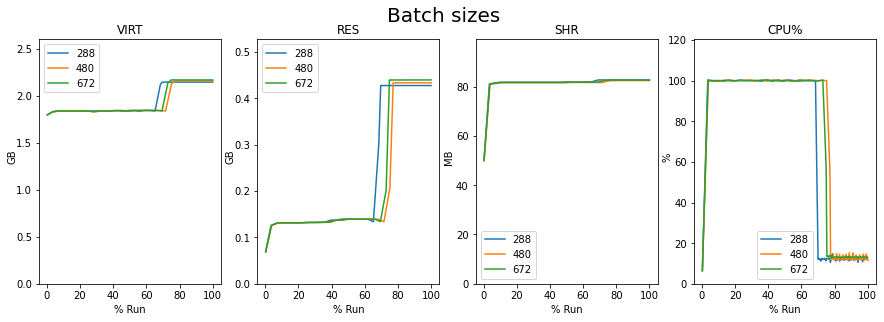

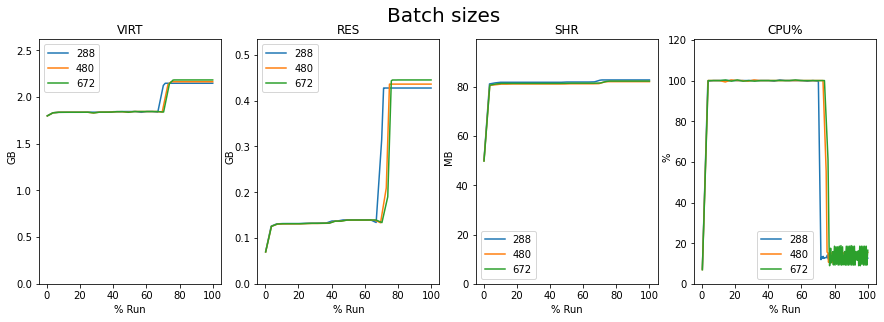

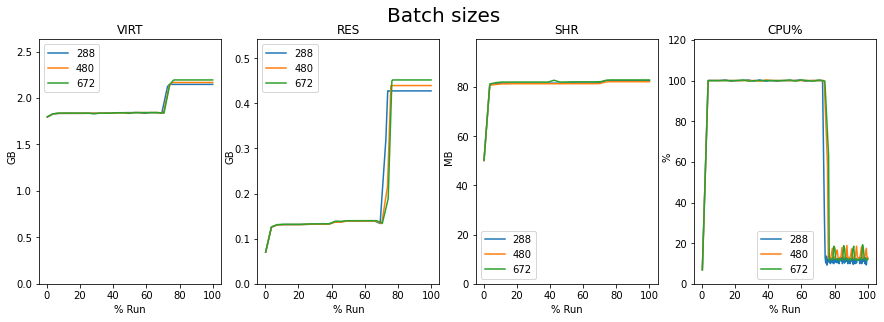

[288, 480, 672]
[288, 480, 672]
[288, 480, 672]
[288, 480, 672]


In [7]:
selected = selected_all[(selected_all['Batch-size']=="1")]
df, maxesmethod_bs1, maxes_axis_bs1 = utils.get_data(selected, verbose=False, maxes_axis=maxes_axis)
utils.plot_analyse(df, maxes_axis_bs1, title="Batch sizes")

selected = selected_all[(selected_all['Batch-size']=="2")]
df, maxesmethod_bs2, maxes_axis_bs2 = utils.get_data(selected, verbose=False, maxes_axis=maxes_axis)
utils.plot_analyse(df, maxes_axis_bs2, title="Batch sizes")

selected = selected_all[(selected_all['Batch-size']=="3")]
df, maxesmethod_bs3, maxes_axis_bs3 = utils.get_data(selected, verbose=False, maxes_axis=maxes_axis)
utils.plot_analyse(df, maxes_axis_bs3, title="Batch sizes")

selected = selected_all[(selected_all['Batch-size']=="4")]
df, maxesmethod_bs4, maxes_axis_bs4 = utils.get_data(selected, verbose=False, maxes_axis=maxes_axis)
utils.plot_analyse(df, maxes_axis_bs4, title="Batch sizes")

print(maxes_axis_bs1)
print(maxes_axis_bs2)
print(maxes_axis_bs3)
print(maxes_axis_bs4)

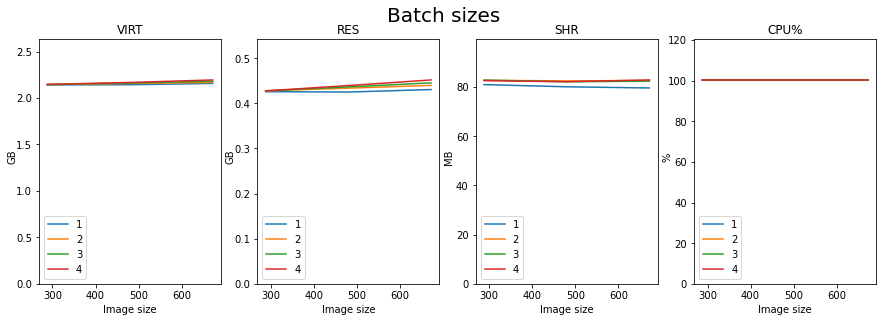

In [9]:
utils.plot_maxes([maxesmethod_bs1, maxesmethod_bs2, maxesmethod_bs3, maxesmethod_bs4], 
                    legends=labels, x_axis=[maxes_axis_bs1, maxes_axis_bs2, maxes_axis_bs3, maxes_axis_bs4], 
                    x_label="Image size", title="Batch sizes")

# Classifiers

## Image sizes

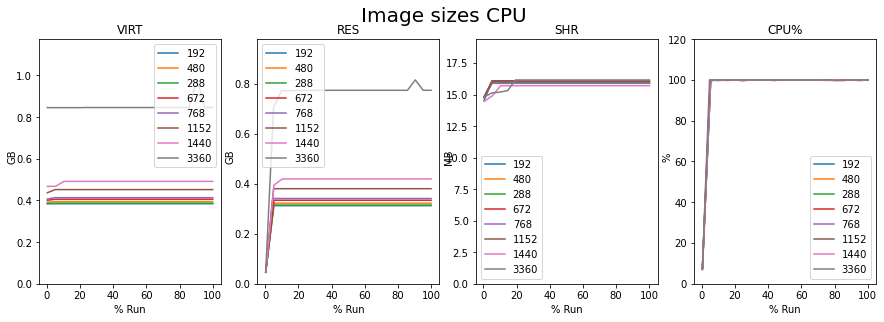

In [14]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="class_models") & 
                    (run_df['Size']!="2080") & 
                    (run_df['Size']!="32") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsclass1 = selected["Size"].unique()
df, maxesmethod1_c = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labelsclass1, title="Image sizes CPU")

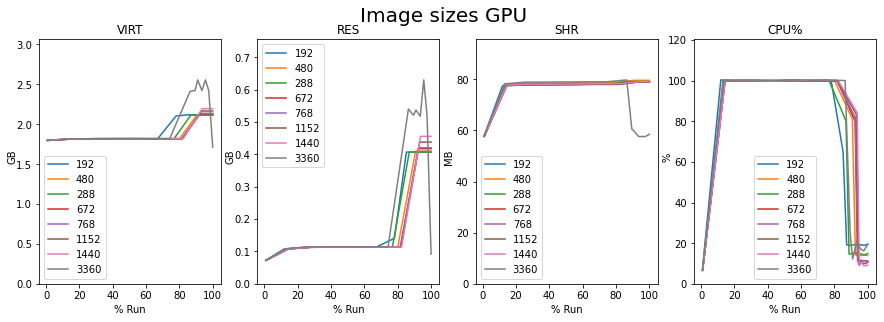

In [15]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="class_models") & 
                    (run_df['Size']!="2080") & 
                    (run_df['Size']!="32") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsclass2 = selected["Size"].unique()
df, maxesmethod2_c = utils.get_data(selected, verbose=False)

utils.plot_analyse(df, labelsclass2, title="Image sizes GPU")

In [18]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']!="4000") & 
                    (run_df['Size']!="3744") & 
                    (run_df['Size']!="3712") & 
                    (run_df['Size']!="2080") &
                    (run_df['Size']!="32") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]

labelsyolo = selected["Size"].unique()
df, maxesmethod1 = utils.get_data(selected, verbose=False)



selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']!="32") & 
                    (run_df['Size']!="4000") & 
                    (run_df['Size']!="3744") & 
                    (run_df['Size']!="2080") & 
                    (run_df['Size']!="3712") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
        

labelsyolo = selected["Size"].unique()
df, maxesmethod2 = utils.get_data(selected, verbose=False)

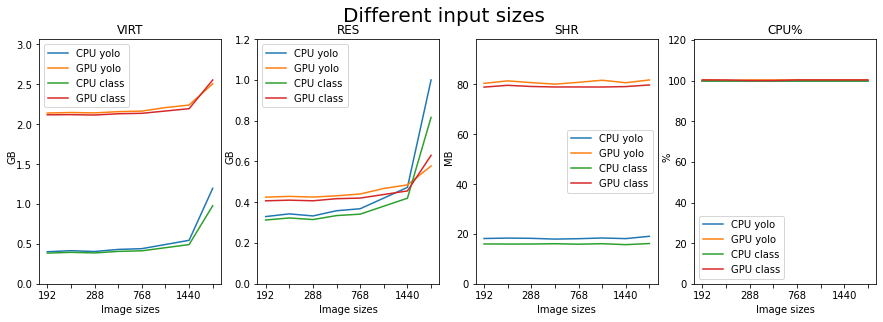

In [20]:
utils.plot_maxes([maxesmethod1, maxesmethod2, maxesmethod1_c, maxesmethod2_c], legends=["CPU yolo", "GPU yolo", "CPU class", "GPU class"], x_axis=[labelsyolo, labelsyolo, labelsclass1, labelsclass2], x_label="Image sizes", title="Different input sizes")

Average diff VIRT: 1.7059266666666666
Average diff RES: 0.08992355555555555
Average diff SHR: 63.221777777777774
Average diff CPU%: 0.1999999999999981


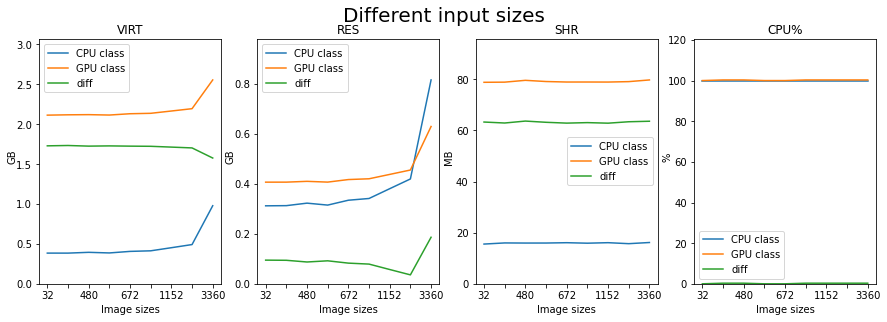

In [13]:
utils.plot_maxes([maxesmethod1_c, maxesmethod2_c], legends=["CPU class", "GPU class"], x_axis=[labelsclass1, labelsclass2], x_label="Image sizes", title="Different input sizes", plot_diff=True)

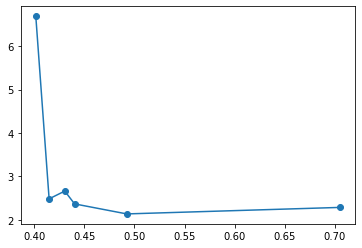

In [17]:
x = [6.688940609, 2.483380744, 2.662849479, 2.36763781, 2.136720789, 2.286779681]
y = [0.40172, 0.415, 0.430604, 0.44036, 0.492376, 0.7051]

plt.plot(y,x)
plt.scatter(y,x)